In [1]:
#import
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import pandas as pd
import numpy as np
import pymysql
import operator
import os
import math
import scipy
from scipy import stats
import statsmodels
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from datetime import *
import scipy.io as sio
import h5py
import copy
import shutil
import rarfile
import random
from general_function import *
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.font_manager import FontProperties
plt.rcParams['font.sans-serif'] = ['SimHei']  #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  #用来正常显示负号
sns.set(style="whitegrid")
myfont = FontProperties(fname=r'C:\Windows\Fonts\simhei.ttf', size=10)
sns.set(font=myfont.get_name(),style="whitegrid",palette="muted",color_codes=True)

In [2]:
n_stock = 30; n_day = 500; n_simulation = 1000; ts_type = 'ar'; posi_cut_point = 0.0945; nega_cut_point = 0.105; use_trick = True

In [3]:
#functions
def multivariate_t_rvs(m, S, df=np.inf, n=1):
    m = np.asarray(m)
    d = len(m)
    if df == np.inf:
        x = 1.
    else:
        x = np.random.chisquare(df, n)/df
    z = np.random.multivariate_normal(np.zeros(d),S,(n,))
    return m + z/np.sqrt(x)[:,None]   # same output format as random.multivariate_normal
def calc(data):
    n = len(data)
    mu = 0.0
    mu2 = 0.0
    mu3 = 0.0
    for a in data:
        mu += a
        mu2 += a**2
        mu3 += a**3
    mu/= n   #这是求E(X)
    mu2 /= n #这是E(X^2)
    mu3 /= n #这是E(X^3)
    sigma = math.sqrt(mu2 - mu*mu)
    return [mu,sigma,mu3]
def calc_stat(data):
    [mu,sigma,mu3] = calc(data)
    n = len(data)
    mu4 = 0.0
    for a in data:
        a -= mu
        mu4 += a ** 4
    mu4 /= n   
    skew = (mu3 - 3*mu*sigma**2 - mu**3)/(sigma**3)
    kurt =  mu4/(sigma**4)-3
    return [mu,sigma,skew,kurt]
def density_gig(x, lamda, sigma, gamma):
    return (gamma/sigma)**lamda*(x**(lamda-1))/(2*scipy.special.kn(lamda,gamma*sigma))*np.exp(-1/2*(sigma**2*x**-1+gamma**2*x))
def sample_from_gig(lamda, sigma, gamma, size):
    x = np.linspace(0,1,1000000)
    density = density_gig(x, lamda, sigma, gamma)
    density[pd.isnull(density)]=0
    return np.random.choice(x, p = density/density.sum(), size = size)
def density_ghst_heavy_tail(x,v,beta):
    return np.abs(x)**(-v/2-1)
def density_ghst_light_tail(x,v,beta):
    return np.abs(x)**(-v/2-1)*np.exp(-2*np.abs(beta)*np.abs(x))
def density_ghst_tail(x,v,beta):
    return np.abs(x)**(-v/2-1)*np.exp(-np.abs(beta)*np.abs(x) + beta*x)
def sample_from_ghst_heavy_tail(v, beta, size, start):
    x = np.linspace(-0.5,-start,100000)
    density = density_ghst_heavy_tail(x,v,beta)
    density[pd.isnull(density)]=0
    return np.random.choice(x, p = density/density.sum(), size = size)
def sample_from_ghst_light_tail(v, beta, size, start):
    x = np.linspace(start,0.5,100000)
    density = density_ghst_light_tail(x,v,beta)
    density[pd.isnull(density)]=0
    return np.random.choice(x, p = density/density.sum(), size = size)
def sample_from_ghst_tail(sign, v, beta, size, start):
    x = np.sort(np.linspace(start,0.5,100000)*sign)
    density = density_ghst_tail(x,v,beta)
    density[pd.isnull(density)]=0
    return np.random.choice(x, p = density/density.sum(), size = size)
def calc_k(v,m4):
    return (1 - np.sqrt(1 - ((3*v**2-2*v-32)*(12*(5*v-22) - (v-6)*(v-8)*m4))/(216*(v-2)**2*(v-4))))/(3*v**2-2*v-32)
def calc_vk(v,m3,m4):
    k = calc_k(v,m4)
    return (4 - 6*(v+2)*(v-2)*k) * np.sqrt(2) * np.sqrt(v-4) * np.sqrt(1-6*(v-2)*(v-4)*k) - m3*(v-6)
def calc_sigma(v,m2,m4):
    return np.sqrt((6*(v-2)**2*(v-4)*m2**2)/(3*v**2-2*v-32) * \
                   (1 - np.sqrt(1 - ((3*v**2-2*v-32)*(12*(5*v-22) - (v-6)*(v-8)*m4))/(216*(v-2)**2*(v-4)))))
def calc_beta(v,m2,m3,m4):
    sigma = calc_sigma(v,m2,m4)
    return (np.sign(m3)*((v-2)**(1/2)*(v-4)**(1/2)*(m2**2*(v-2)-sigma**2)**(1/2))/(np.sqrt(2)*sigma**2))
def calc_miu(v,m1,m2,m3,m4):
    beta = calc_beta(v,m2,m3,m4)
    sigma = calc_sigma(v,m2,m4)
    return m1-(beta*sigma**2)/(v-2)

In [4]:
#read data
os.chdir(r'C:\Users\bj\Desktop\刘泽丹\Code')
dateparse = lambda dates: pd.datetime.strptime(str(date.fromordinal(int(dates)-366)).replace('-',''), '%Y%m%d')
zzIcData = pd.read_csv('zz500_from_db.csv',index_col = 0, date_parser=dateparse)
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y%m%d')
open_p = pd.read_csv('open.csv',index_col = 0, date_parser=dateparse)
close_p = pd.read_csv('close.csv',index_col = 0, date_parser=dateparse)
amt = pd.read_csv('amt.csv',index_col = 0, date_parser=dateparse)
adjfactor = pd.read_csv('adjfactor.csv',index_col = 0, date_parser=dateparse)
open_p.columns = [int(i) for i in open_p.columns]
close_p.columns = [int(i) for i in close_p.columns]
amt.columns = [int(i) for i in amt.columns]
adjfactor.columns = [int(i) for i in adjfactor.columns]
adjopen = adjfactor * open_p
adjclose = adjfactor * close_p
adjpreclose = adjclose.shift(1)
trick = [600009, 2480, 603558, 600833, 300042, 300177, 300682, 300549, 603922, 2312, 813, 300191, 2416, 600093, 300037, 505, 601098,\
         603283, 300632, 603225, 300404, 300169, 600848, 2286, 600775, 300312, 517, 2194, 2940, 2745, 603045, 783, 603056, 600594,\
         601116, 300167, 300315, 2705, 300269, 600807, 626, 300434, 2850, 800, 603323, 601699, 2303, 600768, 603969, 801]

In [5]:
trick = [2099,300378,600602,300204,603160,603222,300579,2481,600963,600155,2322,600565,672,300220,600136,600592,\
         600710,601155,601777,966,600088,2149,922,2461,2077,300421,603042,300690,570,300125]

In [6]:
#some preprocess
close_to_close = np.log(adjclose/adjpreclose)
open_to_close = np.log(adjclose/adjopen)
preclose_to_open = np.log(adjopen/adjpreclose)
# close_to_close = adjclose/adjpreclose - 1
# open_to_close = adjclose/adjopen - 1
# preclose_to_open = adjopen/adjpreclose - 1
amt = amt.replace(0,np.nan)
amt = amt.T.dropna(how='all').T
def get_rid_of_newly_ipos(df):
    return df.iloc[df.index.tolist().index(df[pd.notnull(df)].index[0])+42:]
amt = amt.apply(get_rid_of_newly_ipos)
close_to_close = close_to_close[pd.notnull(amt)].dropna(how='all')
open_to_close = open_to_close[pd.notnull(amt)].dropna(how='all')
preclose_to_open = preclose_to_open[pd.notnull(amt)].dropna(how='all')
zz500 = (zzIcData['5']/(zzIcData['5'].shift(1).fillna(1000)) - 1)
zz500.name = 'zz500'
ghst_density = pd.read_csv('ghst_density1.csv',index_col=0)
def process(df):
    df = df[(df<posi_cut_point)&(df>-nega_cut_point)]
    df = df-df.mean()
    return calc_stat(df)
ghst_density_mid = ghst_density.apply(process)
ghst_density_desc = pd.DataFrame(index=ghst_density_mid.index,columns = ['std','skew','kurt'])
for i in ghst_density_mid.index:
    ghst_density_desc.loc[i,'std'] = ghst_density_mid.loc[i][1]
    ghst_density_desc.loc[i,'skew'] = ghst_density_mid.loc[i][2]
    ghst_density_desc.loc[i,'kurt'] = ghst_density_mid.loc[i][3]

mod_kns = sm.tsa.MarkovRegression(zz500, k_regimes=3, trend='nc', switching_variance=True)
res_kns = mod_kns.fit()

res_kns.expected_durations

correlation = pd.read_csv('20_full_corr.csv',index_col=0,date_parser = \
            lambda dates: pd.datetime.strptime(dates, '%Y%m%d'),header = None)[1]

mod_hamilton = sm.tsa.MarkovRegression(correlation, k_regimes=3)
res_hamilton = mod_hamilton.fit()

res_hamilton.expected_durations

fig, axes = plt.subplots(3, figsize=(10,7))
titles = ['low','medium','high']
for i in range(3):
    ax = axes[i]
    axx = ax.twinx()
    axx.plot(pd.concat([zz500.cumsum(),res_kns.smoothed_marginal_probabilities[i],\
        res_hamilton.smoothed_marginal_probabilities[i]],axis=1).dropna().iloc[:,0],'r')
    axx.grid(False)
    ax.fill_between(pd.concat([zz500.cumsum(),res_kns.smoothed_marginal_probabilities[i],\
        res_hamilton.smoothed_marginal_probabilities[i]],axis=1).dropna().iloc[:,1].index,0,\
                    pd.concat([zz500.cumsum(),res_kns.smoothed_marginal_probabilities[i],\
        res_hamilton.smoothed_marginal_probabilities[i]],axis=1).dropna().iloc[:,1], alpha = 0.5)
    ax.fill_between(pd.concat([zz500.cumsum(),res_kns.smoothed_marginal_probabilities[i],\
        res_hamilton.smoothed_marginal_probabilities[i]],axis=1).dropna().iloc[:,2].index,0,\
                    pd.concat([zz500.cumsum(),res_kns.smoothed_marginal_probabilities[i],\
        res_hamilton.smoothed_marginal_probabilities[i]],axis=1).dropna().iloc[:,2], alpha = 0.5)
    ax.set(title='Smoothed probability of a '+titles[i]+'-correlation regime for stock returns')
fig.tight_layout()

NormaltestResult(statistic=153.06508355907016, pvalue=5.785480299990736e-34)
[0.003126413191563605, 0.031233503211686765, 0.026982693198871206, 3.280903696313862]
#open-to-close#


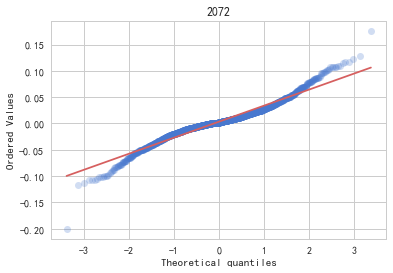

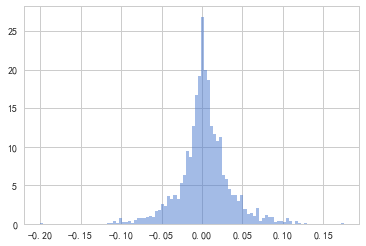

In [8]:
#plot open-to-close
stock = 2072
data = open_to_close[stock].dropna()
fig = plt.figure()
ax1 = plt.subplot(111)
res = stats.probplot(data,dist="norm", plot=plt)
ax1.get_lines()[0].set_alpha(0.25)
print(stats.normaltest(data))
print(calc_stat(data))
print('#open-to-close#')
plt.title(stock)
plt.show()
plt.hist(data, density=True, bins = 100,histtype='stepfilled', alpha=0.5)
plt.show()

NormaltestResult(statistic=529.9822258632976, pvalue=8.238002138969024e-116)
[-0.0031532628462206044, 0.019225041022419342, -0.7340951300594968, 12.492369268869032]
#preclose-to-open#


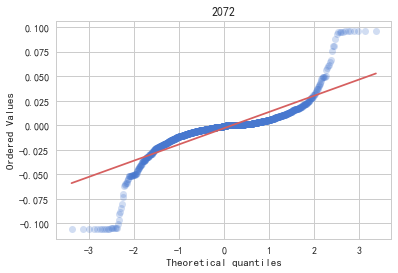

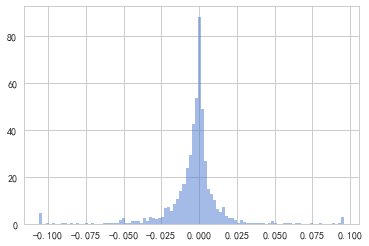

In [9]:
#plot preclose-to-open
data = preclose_to_open[stock].dropna()
fig = plt.figure()
ax1 = plt.subplot(111)
res = stats.probplot(data,dist="norm", plot=plt)
ax1.get_lines()[0].set_alpha(0.25)
print(stats.normaltest(data))
print(calc_stat(data))
print('#preclose-to-open#')
plt.title(stock)
plt.show()
plt.hist(data, density=True, bins = 100,histtype='stepfilled', alpha=0.5)
plt.show()

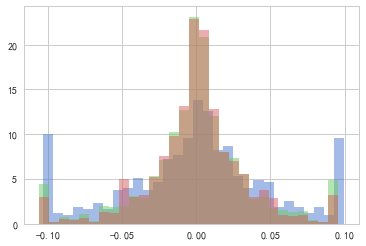

In [10]:
plt.hist(close_to_close[2072][(close_to_close[2072].index>datetime(2010,4,29)) & \
        (close_to_close[2072].index<datetime(2013,5,23))].dropna()*2,density=True,bins=30,alpha=0.5)
plt.hist(close_to_close[2072][(close_to_close[2072].index<=datetime(2010,4,29)) | \
        (close_to_close[2072].index>=datetime(2013,5,23))].dropna(),density=True,bins=30,alpha=0.5)
plt.hist(close_to_close[2072].dropna(),density=True,bins=30,alpha=0.5)
plt.show()

NormaltestResult(statistic=103.26235260225815, pvalue=3.7745487447227056e-23)
[1.4500762304520751e-05, 0.033574586582276224, -0.21388960354200853, 1.9363364123645503]
#preclose-to-close#


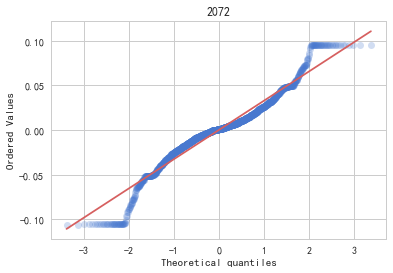

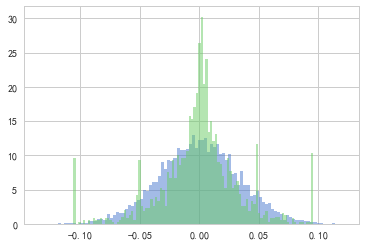

In [11]:
#plot preclose-to-close
data = close_to_close[stock].dropna()
fig = plt.figure()
ax1 = plt.subplot(111)
res = stats.probplot(data,dist="norm", plot=plt)
ax1.get_lines()[0].set_alpha(0.25)
print(stats.normaltest(data))
print(calc_stat(data))
print('#preclose-to-close#')
plt.title(stock)
plt.show()
plt.hist(np.random.normal(loc=0,scale=data.std(),size=10000),bins = 100,histtype='stepfilled', alpha=0.5,density=True)
plt.hist(data, density=True, bins = 100,histtype='stepfilled', alpha=0.5)
plt.show()

In [12]:
while(True):
    result = pd.DataFrame()
    for i in range(n_stock):
        if use_trick:
            stock = trick[i]
        else:
            stock = random.choice(close_to_close.columns)
        x = close_to_close[stock].fillna(0)
        x.name = stock
        result = pd.concat([result,x],axis=1)
    result = result.dropna().iloc[-n_day:]
    if result.columns.value_counts().max() == 1 and result.replace(0,np.nan).T.dropna(how='all').fillna(0).T.shape == result.shape:
        result = pd.concat([result,zz500.iloc[-n_day:]],axis=1).fillna(0)
        break

In [13]:
#simulation
if ts_type == 'ar':
    arma_orders = np.array([[sm.tsa.ARMA(result[col],(1,0)).fit(trend = 'nc').params[0],0] for col in result.columns])
else:
    arma_orders = np.array([[0,sm.tsa.ARMA(result[col],(0,1)).fit(trend = 'nc').params[0]] for col in result.columns])
collibrated_cov = np.array(result.cov())
assert(collibrated_cov.shape[0]==collibrated_cov.shape[1])
assert(arma_orders.shape[0] == collibrated_cov.shape[0])
assert(arma_orders.shape[1] == 2)
assert(not (collibrated_cov != collibrated_cov.T).sum())
eps_cov = np.zeros(collibrated_cov.shape[0]*collibrated_cov.shape[1]).reshape(collibrated_cov.shape[0],collibrated_cov.shape[1])
for i in range(collibrated_cov.shape[0]):
    for j in range(i+1):
        if i == j:
            eps_cov[i,j] = (collibrated_cov[i,j] /\
                (1 + arma_orders[i][1]**2 + 2*arma_orders[i][0]*arma_orders[i][1]) *\
                (1 - arma_orders[i][0]**2))
        else:
            eps_cov[i,j] = eps_cov[j,i] = collibrated_cov[i,j] *\
                (1 - arma_orders[i][0] * arma_orders[j][0]) /\
                (1 + arma_orders[i][0] * arma_orders[j][1] +\
                 arma_orders[j][0] * arma_orders[i][1] +\
                 arma_orders[j][1] * arma_orders[i][1])
simulated_eps = pd.DataFrame(np.random.multivariate_normal([0]*eps_cov.shape[0], eps_cov, n_simulation+1))
simulated_x = pd.DataFrame(0,index=simulated_eps.index,columns=simulated_eps.columns)
for i in simulated_x.index:
    if i == 0:
        continue
    simulated_x.loc[i] = simulated_x.loc[i-1]*pd.DataFrame(arma_orders)[0].tolist() +\
                         simulated_eps.loc[i] +\
                         simulated_eps.loc[i-1]*pd.DataFrame(arma_orders)[1].tolist()
simulated_x = simulated_x.iloc[1:]
try:
    simulated_x.index = zz500.index[-len(simulated_x):]
except:
    simulated_x.index = range(len(simulated_x))
simulated_x.columns = result.columns

pd.DataFrame(collibrated_cov)

result.corr()

pd.DataFrame(eps_cov)

simulated_eps.cov()

simulated_x.cov()

In [14]:
simulated_x[simulated_x>posi_cut_point] = posi_cut_point
simulated_x[simulated_x<-nega_cut_point] = -nega_cut_point

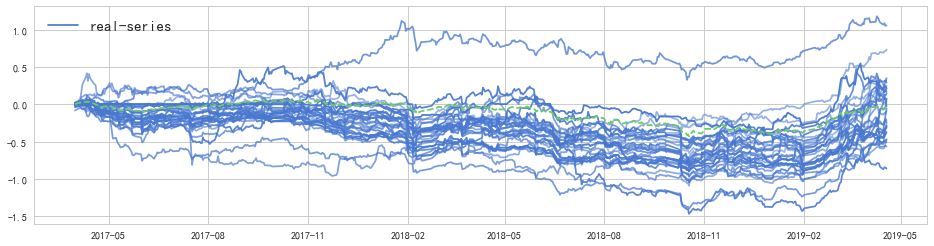

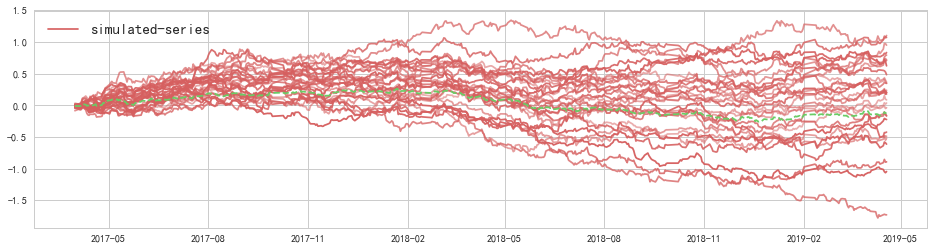

In [15]:
#plot simulation
plt.figure(figsize = (16,4))
for col_index,col in enumerate(result.columns):
    if col == result.columns.tolist()[-2]:
        plt.plot((result[col]).cumsum(),'b',label = 'real-series',alpha=1-(1-col_index/len(result.columns))/2)
    elif col == 'zz500':
        plt.plot((result[col]).cumsum(),'g--',label = '_nolegend_')
    else:
        plt.plot((result[col]).cumsum(),'b',label = '_nolegend_',alpha=1-(1-col_index/len(result.columns))/2)
plt.legend(fontsize = 15)
plt.show()
plt.figure(figsize = (16,4))
for col_index,col in enumerate(simulated_x.columns):
    if col == simulated_x.columns.tolist()[-2]:
        plt.plot((simulated_x[col]).iloc[-n_day:].cumsum(),'r', label = 'simulated-series',alpha=1-(1-col_index/len(simulated_x.columns))/2)
    elif col == 'zz500':
        plt.plot((simulated_x[col]).iloc[-n_day:].cumsum(),'g--',label = '_nolegend_')
    else:    
        plt.plot((simulated_x[col]).iloc[-n_day:].cumsum(),'r', label = '_nolegend_',alpha=1-(1-col_index/len(simulated_x.columns))/2)
plt.legend(fontsize = 15)
plt.show()

NormaltestResult(statistic=133.8007090730477, pvalue=8.82155583772705e-30)
[0.000691704445072375, 0.02201994162859313, 1.0263669828070066, 5.769124861320099]


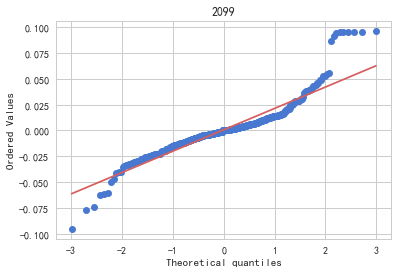

NormaltestResult(statistic=30.944855385237997, pvalue=1.9072605744929865e-07)
[4.2447512969475154e-05, 0.031186441192864265, -0.11558918499124766, 2.219927350812805]


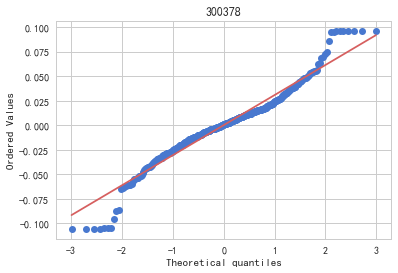

NormaltestResult(statistic=51.09902948217514, pvalue=8.016535731177116e-12)
[0.00032345632411790755, 0.0245056710913614, -0.18493561159910896, 3.6387715381222163]


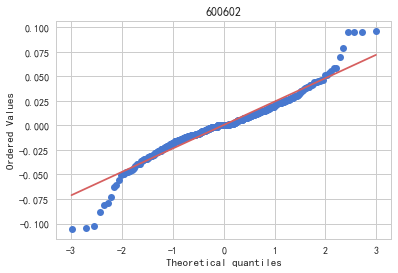

In [16]:
#plot qqplot for real data
for col in result.columns.tolist()[:3]:
    stats.probplot(result[col],dist="norm", plot=plt)
    print(stats.normaltest(result[col]))
    print(calc_stat(result[col]))
    plt.title(col)
    plt.show()

NormaltestResult(statistic=2.077400175021697, pvalue=0.3539144408726439)
[0.0010157187914069006, 0.02196833945059477, 0.08932801604548238, 0.1204388835188146]


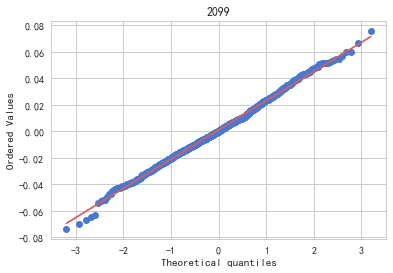

NormaltestResult(statistic=0.38885831016479905, pvalue=0.8233045031301727)
[0.00019678851533547355, 0.030519513379507195, 0.04551086750651402, -0.0466552236827118]


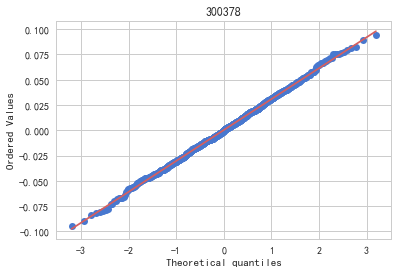

NormaltestResult(statistic=0.9688923906677931, pvalue=0.6160382671792363)
[0.0010780309228442017, 0.024806118930615233, -0.05853499432432867, 0.08141553145962988]


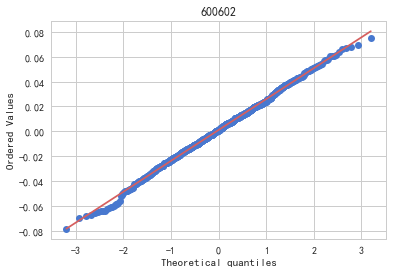

In [17]:
#plot qqplot for simulated data
for col in simulated_x.columns.tolist()[:3]:
    stats.probplot(simulated_x[col],dist="norm", plot=plt)
    print(stats.normaltest(simulated_x[col]))
    print(calc_stat(simulated_x[col]))
    plt.title(col)
    plt.show()

NormaltestResult(statistic=264.37727580402884, pvalue=3.901251861042535e-58)
[0.00043390566856978216, 0.02676691358130285, -0.016388614056815895, 0.5747034050499504]


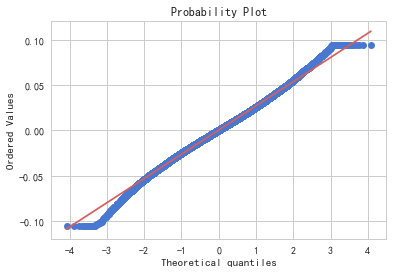

NormaltestResult(statistic=6293.9577242564765, pvalue=0.0)
[-5.7595599214210904e-05, 0.02711967150157924, -1.0372122211469537, 29.14317301664113]


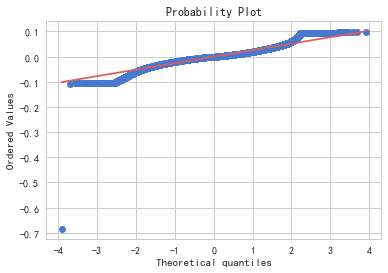

In [18]:
stats.probplot(simulated_x.stack(),dist="norm", plot=plt)
print(stats.normaltest(simulated_x.stack()))
print(calc_stat(simulated_x.stack()))
plt.show()
stats.probplot(result.stack(),dist="norm", plot=plt)
print(stats.normaltest(result.stack()))
print(calc_stat(result.stack()))
plt.show()

In [38]:
def future_value_df_generator(var_list,ret_list,tw = 100):
    var_list.name = 'VaR'
    var_to_test_data = pd.DataFrame(var_list.dropna())
    for i in range(tw):
        var_to_test_data[i] = np.nan
    for i in var_to_test_data.index:
        test_data = ret_list.iloc[ret_list.index.tolist().index(i)+1:].iloc[:tw].reset_index(drop=True)
        if len(test_data) != tw:
            break
        for j in range(tw):
            var_to_test_data.loc[i,j] = test_data.loc[j]
    var_to_test_data.dropna(inplace=True)
    return var_to_test_data
def count_exception(df, tw):
    VaR = df.loc['VaR']
    test_data = df.loc[range(tw)]
    return len(test_data[test_data<VaR])
def kupiec_backtest(df, cl, tw):
    cl_a = 1 - cl
    LRuc_left = -2*np.log((cl**(tw - df.loc['n_exception'])) * (cl_a**df.loc['n_exception']))
    LRuc_right = 2*np.log(((1 - df.loc['n_exception']/tw)**(tw - df.loc['n_exception']) *\
                           ((df.loc['n_exception']/tw)**df.loc['n_exception'])))
    return LRuc_left + LRuc_right
def christoffersen_test(df, tw):
    VaR = df.loc['VaR']
    n_exception = df.loc['n_exception']
    if n_exception == 0 or (n_exception == 1 and df.loc[tw-1] < VaR):
        return 0
    test_data = df.loc[range(tw)].tolist()
    n_00 = len([value for index,value in enumerate(test_data[:-1]) if value > VaR and test_data[index+1] > VaR])
    n_10 = len([value for index,value in enumerate(test_data[:-1]) if value < VaR and test_data[index+1] > VaR])
    n_01 = len([value for index,value in enumerate(test_data[:-1]) if value > VaR and test_data[index+1] < VaR])
    n_11 = len([value for index,value in enumerate(test_data[:-1]) if value < VaR and test_data[index+1] < VaR])
    pi_0 = n_01 / (n_00 + n_01) if n_00 + n_01 != 0 else 0
    pi_1 = n_11 / (n_10 + n_11) if n_10 + n_11 != 0 else 0
    pi = (n_01 + n_11) / (n_00 + n_01 + n_10 + n_11)
    LRcc_up = ((1 - pi)**(n_00 + n_10)) * (pi**(n_01+n_11))
    LRcc_down = ((1 - pi_0)**n_00) * (pi_0**n_01) * ((1 - pi_1)**n_10) * (pi_1**n_11)
    LRcc = -2*np.log(LRcc_up / LRcc_down)
    return LRcc
def exception_test(df, cl):
    LRuc = df.loc['LRuc']
    LRcc = df.loc['LRcc']
    #uc - chi-sqaure 1 df
    #cc - chi-square 2 df
    LRuc_limit = stats.chi2.ppf(cl, df = 1)
    LRcc_limit = stats.chi2.ppf(cl, df = 2)
    if LRcc > LRcc_limit:
        if LRuc + LRcc > LRuc_limit + LRcc_limit:
            return 'reject'
        else:
            return 'accept'
    else:
        if LRuc > LRuc_limit:
            return 'reject'
        else:
            return 'accept'
def backtest_VaR(ret_data, var_data, window = 100, var_cl = 0.95, test_cl = 0.95):
    var_data.name = 'VaR'
    var_confidence_level = var_cl
    test_confidence_level = test_cl
    data =  future_value_df_generator(var_data,ret_data,tw = window)
    data['n_exception'] = data.apply(count_exception,args=(window,),axis=1)
    data['LRuc'] = data.apply(kupiec_backtest,args=(var_confidence_level,window,),axis=1)
    data['LRcc'] = data.apply(christoffersen_test,args=(window,),axis=1)
    data['result'] = data.apply(exception_test,args=(test_confidence_level,),axis=1)
    return data

In [74]:
def count_exception_single_day_var(df):
    df['n_exception'] = 0
    df['n_exception'][df['VaR']>df['future_ret']] = 1
    return df
def kupiec_backtest_single_day_var(df, cl):
    cl_a = 1 - cl
    LRuc_left = -2*np.log((cl**(len(df) - df['n_exception'].sum())) * (cl_a**df['n_exception'].sum()))
    LRuc_right = 2*np.log(((1 - df['n_exception'].sum()/len(df))**(len(df) - df['n_exception'].sum()) *\
                           ((df['n_exception'].sum()/len(df))**df['n_exception'].sum())))
    return LRuc_left + LRuc_right
def christoffersen_test_single_day_var(df):
    VaR = df['VaR']
    n_exception = df['n_exception'].sum()
    if n_exception == 0 or (n_exception == 1 and df['future_ret'].iloc[-1] < VaR.iloc[-1]):
        return 0
    test_data = df['future_ret'].tolist()
    n_00 = len([value for index,value in enumerate(test_data[:-1]) if value > VaR.iloc[index] and test_data[index+1] > VaR.iloc[index+1]])
    n_10 = len([value for index,value in enumerate(test_data[:-1]) if value < VaR.iloc[index] and test_data[index+1] > VaR.iloc[index+1]])
    n_01 = len([value for index,value in enumerate(test_data[:-1]) if value > VaR.iloc[index] and test_data[index+1] < VaR.iloc[index+1]])
    n_11 = len([value for index,value in enumerate(test_data[:-1]) if value < VaR.iloc[index] and test_data[index+1] < VaR.iloc[index+1]])
    pi_0 = n_01 / (n_00 + n_01) if n_00 + n_01 != 0 else 0
    pi_1 = n_11 / (n_10 + n_11) if n_10 + n_11 != 0 else 0
    pi = (n_01 + n_11) / (n_00 + n_01 + n_10 + n_11)
    LRcc_up = ((1 - pi)**(n_00 + n_10)) * (pi**(n_01+n_11))
    LRcc_down = ((1 - pi_0)**n_00) * (pi_0**n_01) * ((1 - pi_1)**n_10) * (pi_1**n_11)
    LRcc = -2*np.log(LRcc_up / LRcc_down)
    return LRcc
def future_value_df_generator_single_day_var(var_list,ret_list):
    var_list.name = 'VaR'
    var_to_test_data = pd.DataFrame(var_list.dropna())
    var_to_test_data['future_ret'] = ret_list.shift(1)
    var_to_test_data.dropna(inplace=True)
    return var_to_test_data
def backtest_VaR_single_day_var(ret_data, var_data, var_confidence_level = 0.95, test_confidence_level = 0.95):
    var_data.name = 'VaR'
    data = future_value_df_generator_single_day_var(var_data,ret_data)
    data = count_exception_single_day_var(data)
    LRuc = kupiec_backtest_single_day_var(data,var_confidence_level)
    LRcc = christoffersen_test_single_day_var(data)
    LRuc_limit = stats.chi2.ppf(test_confidence_level, df = 1)
    LRcc_limit = stats.chi2.ppf(test_confidence_level, df = 2)
    if LRcc > LRcc_limit:
        if LRuc + LRcc > LRuc_limit + LRcc_limit:
            var_backtest_result =  'reject'
        else:
            var_backtest_result = 'accept'
    else:
        if LRuc > LRuc_limit:
            var_backtest_result = 'reject'
        else:
            var_backtest_result = 'accept'
    return data,var_backtest_result

In [162]:
def original_VaR(df, cl):
    cl_a = 1 - cl
    return np.quantile(df,cl_a)
def normal_VaR(df, cl):
    cl_a = 1 - cl
    rn = np.random.normal(loc=df.mean(),scale=df.std(),size=100000)
    return np.quantile(rn,cl_a)
def ghst_VaR(df, cl):
    cl_a = 1 - cl
    m1,m2,m3,m4 = calc_stat(df)
    search_v = dict(zip(np.linspace(0,10,1000),calc_vk(np.linspace(0,10,1000),m3,m4)))
    search_v = {k: search_v[k] for k in search_v if not np.isnan(search_v[k])}
    v = min(search_v, key=lambda x:abs(search_v[x]))
    if v==8:
        v = v + 0.01
    Y = stats.norm.rvs(loc=0,scale=1,size=100000)
    sigma = calc_sigma(v,m2,m4)
    beta = calc_beta(v,m2,m3,m4)
    miu = calc_miu(v,m1,m2,m3,m4)
    gamma = np.sqrt((np.abs(beta)+0.0001)**2 - beta**2)
    Z = sample_from_gig(-v/2,sigma,gamma,100000)
    X = miu+beta*Z+np.sqrt(Z)*Y
    return np.quantile(X,cl_a)

In [163]:
ret_data = result.iloc[:,:-1].mean(axis=1)

In [167]:
var_confidence_level = 0.80
backtest_VaR_single_day_var(ret_data,ret_data.rolling(window = 100).apply(ghst_VaR,args=(var_confidence_level,)),\
                                     var_confidence_level,0.95)[1]

'accept'

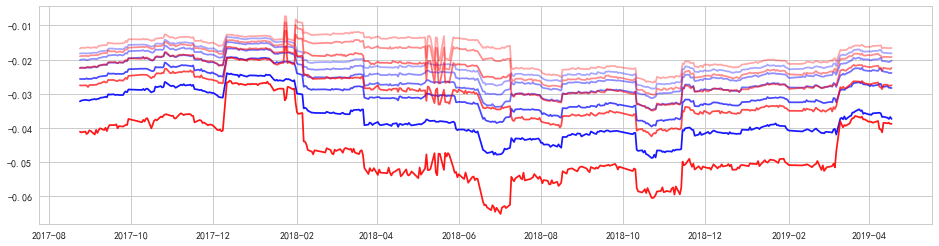

In [164]:
plt.figure(figsize = (16,4))
for var_confidence_level in np.linspace(0.9,0.99,5):
    plt.plot(backtest_VaR_single_day_var(ret_data,ret_data.rolling(window = 100).apply(normal_VaR,args=(var_confidence_level,)),\
                                     var_confidence_level,0.95)[0]['VaR'],'blue',alpha = var_confidence_level**10)
    plt.plot(backtest_VaR_single_day_var(ret_data,ret_data.rolling(window = 100).apply(ghst_VaR,args=(var_confidence_level,)),\
                                     var_confidence_level,0.95)[0]['VaR'],'red',alpha = var_confidence_level**10)

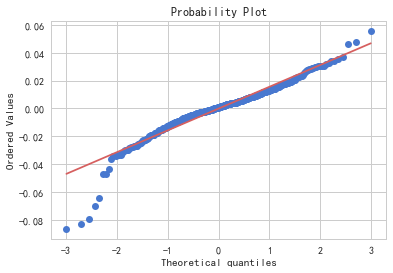

In [166]:
stats.probplot(ret_data,plot=plt)
plt.show()

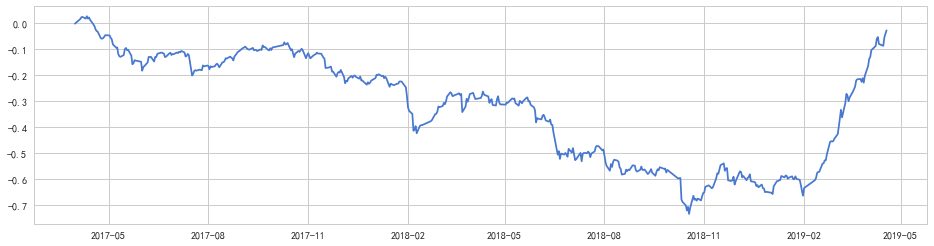

In [19]:
plt.figure(figsize = (16,4))
plt.plot(result.iloc[:,:-1].mean(axis=1).cumsum())

#nov stock example
Y = stats.norm.rvs(loc=0,scale=1,size=100000)
v = 8.6; sigma = 0.021; gamma = 0.167; miu = 0.00193; beta = -14.067
Z = sample_from_gig(-v/2,sigma,gamma,100000)
X = miu+beta*Z+np.sqrt(Z)*Y
fig, ax = plt.subplots(1, 1)
ax.hist(X, density=True,bins = 100,histtype='stepfilled', alpha=0.2)
plt.show()
stats.probplot(X,dist="norm", plot=plt)
plt.show()

calc_stat(X)

#mean
miu+(beta*sigma**2)/(v-2)

#std
np.sqrt((2*beta**2*sigma**4)/((v-2)**2*(v-4))+(sigma**2)/(v-2))

#skewness
((2*(v-4)**(1/2)*beta*sigma)/((2*beta**2*sigma**2+(v-2)*(v-4))**(3/2))) * (3*(v-2) + (8*beta**2*sigma**2)/(v-6))

#kurtosis
6/((2*beta**2*sigma**2+(v-2)*(v-4))**2) * \
((v-2)**2*(v-4) + (16*beta**2*sigma**2*(v-2)*(v-4))/(v-6) + (8*beta**4*sigma**4*(5*v-22))/((v-6)*(v-8)))

In [ ]:
data = result.iloc[:,:-1].stack()
cut_data = data[data<posi_cut_point]
cut_data = cut_data[cut_data>-nega_cut_point]
cut_data = cut_data-cut_data.mean()

In [ ]:
fig = plt.figure()
ax1 = plt.subplot(111)
res = stats.probplot(data,dist="norm", plot=plt)
ax1.get_lines()[0].set_alpha(0.25)
plt.show()
fig = plt.figure()
ax1 = plt.subplot(111)
res = stats.probplot(cut_data,dist="norm", plot=plt)
ax1.get_lines()[0].set_alpha(0.25)
plt.show()

In [ ]:
#find best-fit
ghst_density_desc_result = np.abs(ghst_density_desc - calc_stat(cut_data)[1:])
ghst_density_desc_result['std'] = np.abs((ghst_density_desc_result['std'])/ghst_density_desc_result['std'].std())
ghst_density_desc_result['skew'] = np.abs((ghst_density_desc_result['skew'])/ghst_density_desc_result['skew'].std())
ghst_density_desc_result['kurt'] = np.abs((ghst_density_desc_result['kurt'])/ghst_density_desc_result['kurt'].std())
ghst_density_desc_result['sum'] = ghst_density_desc_result.sum(axis=1)
best_fit = ghst_density_desc_result['sum'].sort_values().index.tolist()[0]
print(best_fit)

In [ ]:
stats.probplot(cut_data, dist = 'norm', plot=plt)
plt.show()
stats.probplot(ghst_density[best_fit].dropna().tolist(), dist = 'norm', plot=plt)
plt.show()

In [ ]:
best_fit_data = np.random.choice(ghst_density[best_fit].dropna().tolist(),len(cut_data))
best_fit_data = best_fit_data-best_fit_data.mean()
plt.plot(sorted(best_fit_data),'b')
plt.plot(cut_data.sort_values().tolist(),'g')
plt.show()

In [ ]:
fitted_beta,fitted_v,fitted_sigma = best_fit[1:-1].split(',')
fitted_beta,fitted_v,fitted_sigma = float(fitted_beta),float(fitted_v),float(fitted_sigma)
data[data>posi_cut_point] = sample_from_ghst_tail(1,fitted_v,fitted_beta,len(data[data>posi_cut_point]),posi_cut_point)
data[data<-nega_cut_point] = sample_from_ghst_tail(-1,fitted_v,fitted_beta,len(data[data<-nega_cut_point]),nega_cut_point)

In [ ]:
fitted_beta,fitted_v,fitted_sigma = best_fit[1:-1].split(',')
fitted_beta,fitted_v,fitted_sigma = float(fitted_beta),float(fitted_v),float(fitted_sigma)
fitted_gamma = np.sqrt((np.abs(fitted_beta)+0.0001)**2 - fitted_beta**2)
fitted_miu = np.mean(cut_data) - (fitted_beta*fitted_sigma**2)/(fitted_v-2)

In [ ]:
Y = stats.norm.rvs(loc=0,scale=1,size=1000000)
Z = sample_from_gig(-fitted_v/2,fitted_sigma,fitted_gamma,1000000)
X = fitted_miu+fitted_beta*Z+np.sqrt(Z)*Y

In [ ]:
fitted_data = np.append(np.random.choice(X[(X<posi_cut_point)&(X>-nega_cut_point)], len(data[(data<posi_cut_point)&(data>-nega_cut_point)])*10),\
np.random.choice(X[(X>posi_cut_point)], len(data[(data>posi_cut_point)])*10))
fitted_data = np.append(fitted_data,\
np.random.choice(X[(X<-nega_cut_point)], len(data[(data<-nega_cut_point)])*10))

In [ ]:
fig = plt.figure()
ax1 = plt.subplot(111)
res = stats.probplot(X,dist="norm", plot=plt)
ax1.get_lines()[0].set_alpha(0.25)
plt.show()

In [ ]:
fig = plt.figure()
ax1 = plt.subplot(111)
res = stats.probplot(fitted_data,dist="norm", plot=plt)
ax1.get_lines()[0].set_alpha(0.25)
plt.show()

In [ ]:
fig = plt.figure()
ax1 = plt.subplot(111)
res = stats.probplot(data,dist="norm", plot=plt)
ax1.get_lines()[0].set_alpha(0.25)
plt.show()

data = fitted_data

In [ ]:
#simulation
m1,m2,m3,m4 = calc_stat(data)
plt.plot(np.linspace(0,20,10000),calc_vk(np.linspace(0,20,10000),m3,m4))
plt.show()
search_v = dict(zip(np.linspace(0,20,10000),calc_vk(np.linspace(0,20,10000),m3,m4)))
search_v = {k: search_v[k] for k in search_v if not np.isnan(search_v[k])}
v = min(search_v, key=lambda x:abs(search_v[x]))
if v==8:
    v = v + 0.01
Y = stats.norm.rvs(loc=0,scale=1,size=1000000)
sigma = calc_sigma(v,m2,m4)
beta = calc_beta(v,m2,m3,m4)
miu = calc_miu(v,m1,m2,m3,m4)
gamma = np.sqrt((np.abs(beta)+0.0001)**2 - beta**2)
Z = sample_from_gig(-v/2,sigma,gamma,1000000)
X = miu+beta*Z+np.sqrt(Z)*Y
normal = stats.norm.rvs(loc=data.mean(),scale=data.std(),size=1000000)
t = stats.t.rvs(df=5,loc=data.mean(),scale=data.std(),size=1000000)

In [ ]:
v,sigma,beta,miu,gamma

In [ ]:
#plot for comparisons
plt.figure(figsize = (16,6))
plt.hist(X, color='red',density=True,bins = 100, alpha=0.75,label = 'simulated')
plt.hist(normal, color='green',density=True,bins = 100, alpha=0.75,label = 'compare-normal')
plt.hist(t, color='orange',density=True,bins = 100, alpha=0.75,label = 'compare-t')
plt.legend()
plt.show()
plt.figure(figsize = (16,6))
plt.hist(normal, color='green',density=True,bins = 100, alpha=0.75,label = 'compare-normal')
plt.hist(data, color='blue',density=True,bins = 100, alpha=0.25,label='real')
plt.legend()
plt.show()
fig = plt.figure()
ax = fig.add_subplot(111)
res = stats.probplot(normal, dist = 'norm', plot=plt)
ax.get_lines()[0].set_markerfacecolor('g')
ax.get_lines()[0].set_alpha(0.25)
res = stats.probplot(data,dist="norm", plot=plt)
ax.get_lines()[0].set_markersize(5)
ax.get_lines()[0].set_alpha(0.25)
plt.show()
plt.figure(figsize = (16,6))
plt.hist(t, color='orange',density=True,bins = 100, alpha=0.75,label = 'compare-t')
plt.hist(data, color='blue',density=True,bins = 100, alpha=0.25,label='real')
plt.legend()
plt.show()
fig = plt.figure()
ax = fig.add_subplot(111)
res = stats.probplot(t, dist = 'norm', plot=plt)
ax.get_lines()[0].set_markerfacecolor('g')
ax.get_lines()[0].set_alpha(0.25)
res = stats.probplot(data,dist="norm", plot=plt)
ax.get_lines()[0].set_markersize(5)
ax.get_lines()[0].set_alpha(0.25)
plt.show()
plt.figure(figsize = (16,6))
plt.hist(X, color='red',density=True,bins = 100, alpha=0.75,label = 'simulated')
plt.hist(data, color='blue',density=True,bins = 100, alpha=0.25,label='real')
plt.legend()
plt.show()
fig = plt.figure()
ax = fig.add_subplot(111)
res = stats.probplot(X, dist = 'norm', plot=plt)
ax.get_lines()[0].set_markerfacecolor('g')
ax.get_lines()[0].set_alpha(0.25)
res = stats.probplot(data,dist="norm", plot=plt)
ax.get_lines()[0].set_markersize(5)
ax.get_lines()[0].set_alpha(0.25)
plt.show()

In [ ]:
#cut-point adjust
X[X>posi_cut_point] = posi_cut_point
X[X<-nega_cut_point] = -nega_cut_point
data[data>posi_cut_point] = posi_cut_point
data[data<-nega_cut_point] = -nega_cut_point
normal[normal>posi_cut_point] = posi_cut_point
normal[normal<-nega_cut_point] = -nega_cut_point
#normal = normal[(normal<posi_cut_point) & (normal>-nega_cut_point)]
t[t>posi_cut_point] = posi_cut_point
t[t<-nega_cut_point] = -nega_cut_point

In [ ]:
#X = np.append(X,np.array([posi_cut_point]*800))

In [ ]:
#plot for comparisons
plt.hist(X, color='red',density=True,bins = 100, alpha=0.5,label = 'simulated')
plt.hist(normal, color='green',density=True,bins = 100, alpha=0.5,label = 'compare-normal')
plt.hist(t, color='orange',density=True,bins = 100, alpha=0.5,label = 'compare-t')
plt.legend()
plt.show()
plt.hist(normal, color='green',density=True,bins = 100, alpha=0.75,label = 'compare-normal')
plt.hist(data, color='blue',density=True,bins = 100, alpha=0.25,label='real')
plt.legend()
plt.show()
fig = plt.figure()
ax = fig.add_subplot(111)
res = stats.probplot(normal, dist = 'norm', plot=plt)
ax.get_lines()[0].set_markerfacecolor('g')
ax.get_lines()[0].set_alpha(0.25)
res = stats.probplot(data,dist="norm", plot=plt)
ax.get_lines()[0].set_markersize(5)
ax.get_lines()[0].set_alpha(0.25)
plt.show()
plt.hist(t, color='orange',density=True,bins = 100, alpha=0.75,label = 'compare-t')
plt.hist(data, color='blue',density=True,bins = 100, alpha=0.25,label='real')
plt.legend()
plt.show()
fig = plt.figure()
ax = fig.add_subplot(111)
res = stats.probplot(t, dist = 'norm', plot=plt)
ax.get_lines()[0].set_markerfacecolor('g')
ax.get_lines()[0].set_alpha(0.25)
res = stats.probplot(data,dist="norm", plot=plt)
ax.get_lines()[0].set_markersize(5)
ax.get_lines()[0].set_alpha(0.25)
plt.show()
plt.hist(X, color='red',density=True,bins = 100, alpha=0.75,label = 'simulated')
plt.hist(data, color='blue',density=True,bins = 100, alpha=0.25,label='real')
plt.legend()
plt.show()
fig = plt.figure()
ax = fig.add_subplot(111)
res = stats.probplot(X, dist = 'norm', plot=plt)
ax.get_lines()[0].set_markerfacecolor('g')
ax.get_lines()[0].set_alpha(0.25)
res = stats.probplot(data,dist="norm", plot=plt)
ax.get_lines()[0].set_markersize(5)
ax.get_lines()[0].set_alpha(0.25)
plt.show()

In [ ]:
[round(i,4) for i in calc_stat(normal)]

In [ ]:
calc_stat(t)

In [ ]:
[round(i,4) for i in calc_stat(X)]

In [ ]:
[round(i,4) for i in calc_stat(data)]

In [ ]:
eps_corr = pd.DataFrame(eps_cov).copy()
for i in range(len(eps_corr)):
    current_std = np.sqrt(eps_corr.iloc[i,i])
    eps_corr.iloc[i,:] = eps_corr.iloc[i,:]/current_std
    eps_corr.iloc[:,i] = eps_corr.iloc[:,i]/current_std

In [ ]:
#simulation
new_simulated_eps = pd.DataFrame(np.random.multivariate_normal([0]*eps_corr.shape[0], eps_corr, n_simulation+1))
new_simulated_mid = sample_from_gig(-v/2,sigma,gamma,n_simulation+1)
def process(df):
    return miu+beta*new_simulated_mid+df*np.sqrt(new_simulated_mid)
new_simulated_eps = new_simulated_eps.apply(process)
new_simulated_x = pd.DataFrame(0,index=new_simulated_eps.index,columns=new_simulated_eps.columns)
for i in new_simulated_x.index:
    if i == 0:
        continue
    new_simulated_x.loc[i] = new_simulated_x.loc[i-1]*pd.DataFrame(arma_orders)[0].tolist() +\
                         new_simulated_eps.loc[i] +\
                         new_simulated_eps.loc[i-1]*pd.DataFrame(arma_orders)[1].tolist()
new_simulated_x = new_simulated_x.iloc[1:]
try:
    new_simulated_x.index = zz500.index[-len(new_simulated_x):]
except:
    new_simulated_x.index = range(len(new_simulated_x))
new_simulated_x.columns = result.columns

In [ ]:
new_simulated_x[new_simulated_x>posi_cut_point] = posi_cut_point
new_simulated_x[new_simulated_x<-nega_cut_point] = -nega_cut_point

In [ ]:
#plot simulation
fig = plt.figure(figsize = (16,4))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax2.grid()
for col_index,col in enumerate(result.columns):
    if col == result.columns.tolist()[-2]:
        ax1.plot((result[col]).cumsum(),'b',label = 'real-series',alpha=1-(1-col_index/len(result.columns))/2)
    elif col == 'zz500':
        ax1.plot((result[col]).cumsum(),'g--',label = '_nolegend_')
    else:
        ax1.plot((result[col]).cumsum(),'b',label = '_nolegend_',alpha=1-(1-col_index/len(result.columns))/2)
#     ax2.plot((result[col]).rolling(window=20).std().iloc[-n_day:],'orange', label = '_nolegend_',\
#                  alpha=(1-(1-col_index/len(result.columns))/2)/2)
    ax2.plot(pd.concat([result['zz500'],result[col]],axis=1)\
             .rolling(window=20).corr().xs('zz500',level=1)[col].iloc[- n_day:],'orange',\
             alpha=(1-(1-col_index/len(result.columns))/2)/2)
ax1.plot((result.iloc[:,:-1].mean(axis=1)).cumsum(),'black',label='_nolegend_')
ax1.legend(fontsize = 15)
plt.show()

fig = plt.figure(figsize = (16,4))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax2.grid()
for col_index,col in enumerate(new_simulated_x.columns):
    if col == new_simulated_x.columns.tolist()[-2]:
        ax1.plot((new_simulated_x[col]).iloc[- n_day:].cumsum(),'r', label = 'simulated-series',\
                 alpha=1-(1-col_index/len(new_simulated_x.columns))/2)
    elif col == 'zz500':
        ax1.plot((new_simulated_x[col]).iloc[- n_day:].cumsum(),'g--',label = '_nolegend_')
    else:
        ax1.plot((new_simulated_x[col]).iloc[- n_day:].cumsum(),'r', label = '_nolegend_',\
                 alpha=1-(1-col_index/len(new_simulated_x.columns))/2)
#     ax2.plot((new_simulated_x[col]).rolling(window=20).std().iloc[- n_day:],'orange', label = '_nolegend_',\
#                  alpha=(1-(1-col_index/len(new_simulated_x.columns))/2)/2)
    ax2.plot(pd.concat([new_simulated_x['zz500'],new_simulated_x[col]],axis=1)\
             .rolling(window=20).corr().xs('zz500',level=1)[col].iloc[- n_day:],'orange',\
             alpha=(1-(1-col_index/len(new_simulated_x.columns))/2)/2)
ax1.plot((new_simulated_x.iloc[:,:-1].mean(axis=1)).iloc[- n_day:].cumsum(),'black',label='_nolegend_')
ax1.legend(fontsize = 15)
plt.show()

In [ ]:
#plot qqplot for simulated data
for col in new_simulated_x.columns.tolist()[:3]:
    fig = plt.figure()
    ax1 = plt.subplot(111)
    res = stats.probplot(new_simulated_x[col],dist="norm", plot=plt)
    ax1.get_lines()[0].set_alpha(0.25)
    print(stats.normaltest(new_simulated_x[col]))
    print(calc_stat(new_simulated_x[col]))
    plt.title(col)
    plt.show()

In [ ]:
#compare plot
pu = np.random.choice(simulated_x.stack(),len(result.stack()))
pu = simulated_x.stack()
print(calc_stat(pu))
fig = plt.figure()
ax1 = plt.subplot(111)
res = stats.probplot(pu,dist="norm", plot=plt)
ax1.get_lines()[0].set_alpha(0.25)
plt.show()

#pu = np.append(np.random.choice(new_simulated_x.stack(),len(result.stack())), np.array([-0.09,-0.105,-0.106,-0.104,-0.1,-0.103,]))
pu = np.random.choice(new_simulated_x.stack(),len(result.stack()))
pu = new_simulated_x.stack()
print(calc_stat(pu))
fig = plt.figure()
ax1 = plt.subplot(111)
res = stats.probplot(pu,dist="norm", plot=plt)
ax1.get_lines()[0].set_alpha(0.25)
plt.show()

print(calc_stat(result.stack()))
fig = plt.figure()
ax1 = plt.subplot(111)
res = stats.probplot(result.stack(),dist="norm", plot=plt)
ax1.get_lines()[0].set_alpha(0.25)
plt.show()

In [ ]:
#adjustment
adjust = (new_simulated_x.iloc[:,:-1].mean(axis=1) - new_simulated_x.iloc[:,-1]).mean() - \
         (result.iloc[:,:-1].mean(axis=1) - result.iloc[:,-1]).mean()
adjusted_new_simulated_x = new_simulated_x.copy()
adjusted_new_simulated_x.iloc[:,:-1] = new_simulated_x.iloc[:,:-1] - adjust

In [ ]:
#plot simulation
fig = plt.figure(figsize = (16,4))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax2.grid()
for col_index,col in enumerate(result.columns):
    if col == result.columns.tolist()[-2]:
        ax1.plot((result[col]).cumsum(),'b',label = 'real-series',alpha=1-(1-col_index/len(result.columns))/2)
    elif col == 'zz500':
        ax1.plot((result[col]).cumsum(),'g--',label = '_nolegend_')
    else:
        ax1.plot((result[col]).cumsum(),'b',label = '_nolegend_',alpha=1-(1-col_index/len(result.columns))/2)
#     ax2.plot((result[col]).rolling(window=20).std().iloc[-n_day:],'orange', label = '_nolegend_',\
#                  alpha=(1-(1-col_index/len(result.columns))/2)/2)
#     ax2.plot(pd.concat([result['zz500'],result[col]],axis=1)\
#              .rolling(window=20).corr().xs('zz500',level=1)[col].iloc[- n_day:],'orange',\
#              alpha=(1-(1-col_index/len(result.columns))/2)/2)
ax1.plot((result.iloc[:,:-1].mean(axis=1)).cumsum(),'black',label='_nolegend_')
ax1.legend(fontsize = 15)
plt.show()

fig = plt.figure(figsize = (16,4))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax2.grid()
for col_index,col in enumerate(new_simulated_x.columns):
    if col == new_simulated_x.columns.tolist()[-2]:
        ax1.plot((new_simulated_x[col]).iloc[- n_day:].cumsum(),'r', label = 'simulated-series',\
                 alpha=1-(1-col_index/len(new_simulated_x.columns))/2)
    elif col == 'zz500':
        ax1.plot((new_simulated_x[col]).iloc[- n_day:].cumsum(),'g--',label = '_nolegend_')
    else:
        ax1.plot((new_simulated_x[col]).iloc[- n_day:].cumsum(),'r', label = '_nolegend_',\
                 alpha=1-(1-col_index/len(new_simulated_x.columns))/2)
#     ax2.plot((new_simulated_x[col]).rolling(window=20).std().iloc[- n_day:],'orange', label = '_nolegend_',\
#                  alpha=(1-(1-col_index/len(new_simulated_x.columns))/2)/2)
#     ax2.plot(pd.concat([new_simulated_x['zz500'],new_simulated_x[col]],axis=1)\
#              .rolling(window=20).corr().xs('zz500',level=1)[col].iloc[- n_day:],'orange',\
#              alpha=(1-(1-col_index/len(new_simulated_x.columns))/2)/2)
ax1.plot((new_simulated_x.iloc[:,:-1].mean(axis=1)).iloc[- n_day:].cumsum(),'black',label='_nolegend_')
ax1.legend(fontsize = 15)
plt.show()

In [ ]:
v, sigma, gamma, miu, beta

In [ ]:
eps = pd.DataFrame(np.random.multivariate_normal([0]*2, np.array([[1,0],[0,1]]), 100))
mid = sample_from_gig(-v/2,sigma,gamma,n_simulation+1)
def process(df):
    return miu+beta*new_simulated_mid+df*np.sqrt(new_simulated_mid)
new_simulated_eps = new_simulated_eps.apply(process)

In [ ]:
eps = pd.DataFrame(np.random.multivariate_normal([0]*2, np.array([[1,0.9],[0.9,1]]), 1000000))

In [ ]:
eps.corr()

In [ ]:
mid = sample_from_gig(-8.26/2,0.9,0.03,1000000)
def process(df):
    return 0.003+-4.5*mid+df*np.sqrt(mid)
eps = eps.apply(process)

In [ ]:
eps.corr()

In [ ]:
a = sample_from_gig(-8.26/2,0.06,0.03,1000000)
mid = pd.DataFrame([a,a]).T

In [ ]:
mid.corr()

In [ ]:
([0.003,0.003] + mid*[-4.5,-4.5] + eps*np.sqrt(mid)).corr()

In [ ]:
plt.hist(result.stack(),bins=100,density=True)
plt.show()